In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/multi-platform-social-sentiment-evolution/multi_platform_social_sentiment_evolution.csv
/kaggle/input/multi-platform-social-sentiment-evolution/README_social_sentiment.md
/kaggle/input/multi-platform-social-sentiment-evolution/column_descriptions_social_sentiment.md


In [2]:
import pandas as pd
import numpy as np
import re
import joblib
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

nltk.download('vader_lexicon', quiet=True)
sia = SentimentIntensityAnalyzer()

In [3]:
DATA_PATH = "/kaggle/input/multi-platform-social-sentiment-evolution/multi_platform_social_sentiment_evolution.csv"
df = pd.read_csv(DATA_PATH)

# Preview
print("Shape:", df.shape)
print("Sample rows:")
display(df.head())

Shape: (150000, 31)
Sample rows:


,post_id,platform,timestamp,date,hour_of_day,day_of_week,is_weekend,user_id,followers,account_age_days,...,shares,comments,views,total_engagement,engagement_rate_per_1k_followers,hours_since_post,viral_coefficient,cross_platform_spread,toxicity_score,location
0,TIK20250419000000,TikTok,2025-04-19 01:56:55,2025-04-19,1,5,1,user_426711,137,306,...,0,0,0,0,0.00,37.1,0.00,0,29.4,Asia
1,TWI20250419000001,Twitter,2025-04-19 05:34:09,2025-04-19,5,5,1,user_221610,1974,2310,...,0,0,105,3,1.52,37.1,0.08,0,3.3,South America
2,INS20250419000002,Instagram,2025-04-19 06:33:36,2025-04-19,6,5,1,user_7998,6471,1990,...,0,0,26,2,0.31,21.0,0.10,0,25.3,Europe
3,INS20250419000003,Instagram,2025-04-19 06:42:16,2025-04-19,6,5,1,user_313440,1366,2057,...,16,8,3057,98,71.74,47.1,2.08,0,3.1,Europe
4,RED20250419000004,Reddit,2025-04-19 06:46:49,2025-04-19,6,5,1,user_23343,1349,1445,...,0,0,0,0,0.00,10.0,0.00,0,52.7,Asia


In [4]:
zero_likes = (df['likes'] == 0).sum()
more_than_zero_likes = (df['likes'] > 0).sum()

print("Rows with 0 likes:", zero_likes)
print("Rows with >0 likes:", more_than_zero_likes)


Rows with 0 likes: 51053
Rows with >0 likes: 98947


In [5]:
df.head(20)


,post_id,platform,timestamp,date,hour_of_day,day_of_week,is_weekend,user_id,followers,account_age_days,...,shares,comments,views,total_engagement,engagement_rate_per_1k_followers,hours_since_post,viral_coefficient,cross_platform_spread,toxicity_score,location
0,TIK20250419000000,TikTok,2025-04-19 01:56:55,2025-04-19,1,5,1,user_426711,137,306,...,0,0,0,0,0.00,37.1,0.00,0,29.4,Asia
1,TWI20250419000001,Twitter,2025-04-19 05:34:09,2025-04-19,5,5,1,user_221610,1974,2310,...,0,0,105,3,1.52,37.1,0.08,0,3.3,South America
2,INS20250419000002,Instagram,2025-04-19 06:33:36,2025-04-19,6,5,1,user_7998,6471,1990,...,0,0,26,2,0.31,21.0,0.10,0,25.3,Europe
3,INS20250419000003,Instagram,2025-04-19 06:42:16,2025-04-19,6,5,1,user_313440,1366,2057,...,16,8,3057,98,71.74,47.1,2.08,0,3.1,Europe
4,RED20250419000004,Reddit,2025-04-19 06:46:49,2025-04-19,6,5,1,user_23343,1349,1445,...,0,0,0,0,0.00,10.0,0.00,0,52.7,Asia
5,RED20250419000005,Reddit,2025-04-19 07:55:21,2025-04-19,7,5,1,user_19777,124,1400,...,0,1,493,15,120.97,22.3,0.67,0,0.0,Asia
6,FAC20250419000006,Facebook,2025-04-19 08:04:37,2025-04-19,8,5,1,user_157662,265,57,...,0,0,0,0,0.00,12.0,0.00,0,23.0,North America
7,INS20250419000007,Instagram,2025-04-19 08:06:54,2025-04-19,8,5,1,user_146900,3433,3566,...,0,0,0,0,0.00,2.3,0.00,0,44.7,Asia
8,RED20250419000008,Reddit,2025-04-19 08:10:46,2025-04-19,8,5,1,user_432927,83,2490,...,0,0,13,1,12.05,33.2,0.03,0,0.0,Europe
9,INS20250419000009,Instagram,2025-04-19 08:13:38,2025-04-19,8,5,1,user_141932,18079,688,...,52,24,5359,551,30.48,40.8,13.52,0,6.4,Europe


In [6]:
df.columns.tolist()

['post_id',
 'platform',
 'timestamp',
 'date',
 'hour_of_day',
 'day_of_week',
 'is_weekend',
 'user_id',
 'followers',
 'account_age_days',
 'verified',
 'topic',
 'language',
 'content_length',
 'media_type',
 'num_hashtags',
 'sentiment_category',
 'sentiment_positive',
 'sentiment_negative',
 'sentiment_neutral',
 'likes',
 'shares',
 'comments',
 'views',
 'total_engagement',
 'engagement_rate_per_1k_followers',
 'hours_since_post',
 'viral_coefficient',
 'cross_platform_spread',
 'toxicity_score',
 'location']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   post_id                           150000 non-null  object 
 1   platform                          150000 non-null  object 
 2   timestamp                         150000 non-null  object 
 3   date                              150000 non-null  object 
 4   hour_of_day                       150000 non-null  int64  
 5   day_of_week                       150000 non-null  int64  
 6   is_weekend                        150000 non-null  int64  
 7   user_id                           150000 non-null  object 
 8   followers                         150000 non-null  int64  
 9   account_age_days                  150000 non-null  int64  
 10  verified                          150000 non-null  int64  
 11  topic                             150000 non-null  o

In [8]:
df.isnull().sum()

post_id                             0
platform                            0
timestamp                           0
date                                0
hour_of_day                         0
day_of_week                         0
is_weekend                          0
user_id                             0
followers                           0
account_age_days                    0
verified                            0
topic                               0
language                            0
content_length                      0
media_type                          0
num_hashtags                        0
sentiment_category                  0
sentiment_positive                  0
sentiment_negative                  0
sentiment_neutral                   0
likes                               0
shares                              0
comments                            0
views                               0
total_engagement                    0
engagement_rate_per_1k_followers    0
hours_since_

In [9]:
df.describe(include="all")

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,post_id,platform,timestamp,date,hour_of_day,day_of_week,is_weekend,user_id,followers,account_age_days,...,shares,comments,views,total_engagement,engagement_rate_per_1k_followers,hours_since_post,viral_coefficient,cross_platform_spread,toxicity_score,location
count,150000,150000,150000,150000,150000.000000,150000.000000,150000.000000,150000,1.500000e+05,150000.000000,...,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000
unique,150000,6,148242,184,NaN,NaN,NaN,129556,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
top,FAC20251018149999,Twitter,2025-07-05 17:21:51,2025-09-22,NaN,NaN,NaN,user_283647,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,North America
freq,1,44676,3,4286,NaN,NaN,NaN,6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52409
mean,NaN,NaN,NaN,NaN,16.647933,2.875440,0.276107,NaN,2.553545e+04,1842.492033,...,52.823820,30.179667,9.790219e+03,437.425913,57.274864,24.044388,55.553609,0.012973,23.813532,NaN
std,NaN,NaN,NaN,NaN,3.839549,2.038426,0.447072,NaN,6.501271e+05,1044.491836,...,406.558451,238.394866,7.608802e+04,3133.847108,321.476433,13.819392,1339.220297,0.113160,25.682093,NaN
min,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,NaN,0.000000e+00,30.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,14.000000,1.000000,0.000000,NaN,9.100000e+01,938.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,12.100000,0.000000,0.000000,1.075000,NaN
50%,NaN,NaN,NaN,NaN,17.000000,3.000000,0.000000,NaN,4.810000e+02,1848.000000,...,0.000000,0.000000,7.800000e+01,3.000000,4.180000,24.100000,0.170000,0.000000,14.800000,NaN
75%,NaN,NaN,NaN,NaN,20.000000,5.000000,1.000000,NaN,2.766250e+03,2746.000000,...,4.000000,2.000000,8.250000e+02,40.000000,27.030000,36.000000,2.390000,0.000000,38.500000,NaN


In [10]:
df.sample(10)

,post_id,platform,timestamp,date,hour_of_day,day_of_week,is_weekend,user_id,followers,account_age_days,...,shares,comments,views,total_engagement,engagement_rate_per_1k_followers,hours_since_post,viral_coefficient,cross_platform_spread,toxicity_score,location
144630,TWI20251002144630,Twitter,2025-10-02 15:17:05,2025-10-02,15,3,0,user_351980,281,939,...,2,2,167,28,99.64,40.0,0.70,0,14.7,Unknown
90554,TWI20251017090554,Twitter,2025-10-17 20:32:22,2025-10-17,20,4,0,user_198652,1,3494,...,0,0,0,0,0.00,7.0,0.00,0,61.3,North America
117503,TWI20250709117503,Twitter,2025-07-09 22:18:36,2025-07-09,22,2,0,user_355029,1686,752,...,0,0,53,2,1.19,19.7,0.10,0,0.0,North America
64221,TWI20250822064221,Twitter,2025-08-22 20:52:59,2025-08-22,20,4,0,user_212029,166,2774,...,0,0,14,2,12.05,19.5,0.10,0,9.2,Asia
119080,FAC20250714119080,Facebook,2025-07-14 20:07:32,2025-07-14,20,0,0,user_235478,21,2112,...,0,0,131,5,238.10,9.3,0.54,0,7.6,Unknown
46501,FAC20250716046501,Facebook,2025-07-16 17:30:22,2025-07-16,17,2,0,user_176278,322,2818,...,0,0,0,0,0.00,9.7,0.00,0,0.0,Europe
110560,TWI20250618110560,Twitter,2025-06-18 14:02:42,2025-06-18,14,2,0,user_177519,443,2195,...,0,0,66,3,6.77,11.3,0.27,0,19.0,Europe
25778,TIK20250605025778,TikTok,2025-06-05 14:35:01,2025-06-05,14,3,0,user_260326,15186,1617,...,18,5,690,103,6.78,2.2,46.50,0,40.5,North America
46459,INS20250716046459,Instagram,2025-07-16 16:59:06,2025-07-16,16,2,0,user_17865,15191,3511,...,4,7,3900,97,6.39,41.3,2.35,0,9.4,Europe
43536,RED20250710043536,Reddit,2025-07-10 13:23:06,2025-07-10,13,3,0,user_316458,79,1174,...,0,0,0,0,0.00,7.5,0.00,0,69.9,Europe


In [11]:
if "timestamp" in df.columns:
    df["timestamp"].head()
else:
    print("No timestamp column")

In [12]:
for col in ["platform", "language", "sentiment", "emotion", "topic", "hashtags"]:
    if col in df.columns:
        print(f"\nUnique values in {col}:")
        print(df[col].unique()[:50])



Unique values in platform:
['TikTok' 'Twitter' 'Instagram' 'Reddit' 'Facebook' 'YouTube']

Unique values in language:
['English' 'Spanish' 'French' 'Korean' 'German' 'Portuguese' 'Hindi'
 'Chinese' 'Arabic' 'Japanese']

Unique values in topic:
['Finance' 'Food' 'Sports' 'Education' 'Gaming' 'Climate' 'Business'
 'Travel' 'Fashion' 'Politics' 'Health' 'Entertainment' 'Science' 'AI/ML'
 'Technology']


In [24]:
# Sanity check
print("target mean:", df['engagement_rate_per_1k_followers'].mean())
print("target median:", df['engagement_rate_per_1k_followers'].median())
print("target min,max:", df['engagement_rate_per_1k_followers'].min(), df['engagement_rate_per_1k_followers'].max())



target mean: 57.2748642
target median: 4.18
target min,max: 0.0 28076.92


NameError: name 'rows' is not defined

In [19]:
!pip install transformers
!pip install detoxify
!pip install torch --upgrade
!pip install detect

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

In [15]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import mean_squared_error
# from xgboost import XGBRegressor
# import joblib


# # ------------------------------
# target = "engagement_rate_per_1k_followers"

# features = [
#     "platform", 
#     "followers", 
#     "account_age_days", 
#     "verified",
#     "media_type",
#     "location",
#     "topic",
#     "language",
#     "content_length",
#     "num_hashtags",
#     "sentiment_positive",
#     "sentiment_negative",
#     "sentiment_neutral",
#     "toxicity_score",
#     "day_of_week",
#     "hour_of_day",
#     "cross_platform_spread"
# ]

# X = df[features]
# y = df[target]

# # ------------------------------
# # Preprocessing
# # ------------------------------
# categorical = ["platform", "media_type", "location", "topic", "language"]
# numeric = [col for col in features if col not in categorical]

# preprocessor = ColumnTransformer([
#     ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
#     ("num", "passthrough", numeric)
# ])

# # ------------------------------
# # Model
# # ------------------------------
# model = XGBRegressor(
#     n_estimators=600,
#     learning_rate=0.05,
#     max_depth=10,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     objective="reg:squarederror"
# )

# pipeline = Pipeline([
#     ("prep", preprocessor),
#     ("model", model)
# ])

# # ------------------------------
# # Train-test split
# # ------------------------------
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# # ------------------------------
# # Train
# # ------------------------------
# pipeline.fit(X_train, y_train)

# # ------------------------------
# # Evaluate
# # ------------------------------
# preds = pipeline.predict(X_test)
# rmse = mean_squared_error(y_test, preds, squared=False)
# print("RMSE:", rmse)

# # ------------------------------
# # Save model
# # ------------------------------
# joblib.dump(pipeline, "best_time_model.pkl")
# print("Model saved as best_time_model.pkl")


RMSE: 318.26934905533966
Model saved as best_time_model.pkl


In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import joblib

# --------------------------------------------------------
# CONFIG
# --------------------------------------------------------
TARGET = "engagement_rate_per_1k_followers"
CATEGORICAL = ["platform", "media_type", "location", "topic", "language"]

FEATURES = [
    "platform", 
    "followers", 
    "account_age_days", 
    "verified",
    "media_type",
    "location",
    "topic",
    "language",
    "content_length",
    "num_hashtags",
    "sentiment_positive",
    "sentiment_negative",
    "sentiment_neutral",
    "toxicity_score",
    "day_of_week",
    "hour_of_day",
    "cross_platform_spread"
]

X = df[FEATURES]
y = df[TARGET]

NUMERIC = [c for c in FEATURES if c not in CATEGORICAL]

# --------------------------------------------------------
# PREPROCESSING
# --------------------------------------------------------
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), CATEGORICAL),
    ("num", "passthrough", NUMERIC)
])

# --------------------------------------------------------
# MODELS TO COMPARE
# --------------------------------------------------------
models = {
    "XGBoost": XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=10,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror"
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=800,
        learning_rate=0.03,
        max_depth=-1,
        num_leaves=64
    ),
    "CatBoost": CatBoostRegressor(
        iterations=800,
        learning_rate=0.03,
        depth=10,
        verbose=0
    )
}

# --------------------------------------------------------
# SPLIT DATA
# --------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

best_rmse = float("inf")
best_model = None
best_name = None

# --------------------------------------------------------
# TRAIN + EVALUATE
# --------------------------------------------------------
for name, model_obj in models.items():

    print("\nTraining:", name)

    pipeline = Pipeline([
        ("prep", preprocessor),
        ("model", model_obj)
    ])

    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)

    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)

    print(f"{name} RMSE: {rmse:.3f}, R2: {r2:.3f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_name = name
        best_model = pipeline

print("\nBest Model:", best_name, "| RMSE:", best_rmse)

# --------------------------------------------------------
# FEATURE IMPORTANCE
# --------------------------------------------------------
print("\nCalculating permutation feature importance...")

perm = permutation_importance(
    best_model, X_test, y_test, n_repeats=10, random_state=42
)

importance_df = pd.DataFrame({
    "feature": FEATURES,
    "importance": perm.importances_mean
}).sort_values("importance", ascending=False)

print("\nFeature Importance:\n", importance_df)

importance_df.to_csv("feature_importance.csv", index=False)
print("Saved feature importance → feature_importance.csv")

# --------------------------------------------------------
# SAVE FINAL MODEL
# --------------------------------------------------------
joblib.dump(best_model, "best_time_model.pkl")
print("\nModel saved as best_time_model.pkl")



Training: XGBoost
XGBoost RMSE: 318.269, R2: -0.040

Training: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1916
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 55
[LightGBM] [Info] Start training from score 57.359748
LightGBM RMSE: 310.233, R2: 0.012

Training: CatBoost
CatBoost RMSE: 310.463, R2: 0.011

Best Model: LightGBM | RMSE: 310.23310123181056

Calculating permutation feature importance...

Feature Importance:
                   feature  importance
16  cross_platform_spread    0.353648
1               followers    0.239354
13         toxicity_score    0.107989
11     sentiment_negative    0.073740
10     sentiment_positive    0.053238
12      sentiment_neutral    0.042168
2        account_age_days    0.003516
6        

In [43]:
import joblib
import pandas as pd
import numpy as np
import re

# ---------------------------------------------------
# LOAD TRAINED MODEL
# ---------------------------------------------------
model = joblib.load("best_time_model.pkl")


# ---------------------------------------------------
# IMPORT NLP MODELS
# ---------------------------------------------------
from transformers import pipeline
# from langdetect import detect
from detoxify import Detoxify

# ------------------------------
# 1. Zero-shot Topic Classifier
# ------------------------------
topic_classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli"
)

TOPIC_OPTIONS = [
    "Finance", "Food", "Sports", "Education", "Gaming", "Climate",
    "Business", "Travel", "Fashion", "Politics", "Health",
    "Entertainment", "Science", "AI/ML", "Technology"
]

def infer_topic(caption):
    result = topic_classifier(caption, TOPIC_OPTIONS)
    return result["labels"][0]


# ------------------------------
# 2. LANGUAGE DETECTION (Transformer)
# ------------------------------
lang_detector = pipeline(
    "text-classification",
    model="papluca/xlm-roberta-base-language-detection"
)

def infer_language(caption):
    result = lang_detector(caption)[0]["label"]
    return result.lower()



# ------------------------------
# 3. Sentiment Analysis
# ------------------------------
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-xlm-roberta-base-sentiment"
)


def infer_sentiment(caption):

    # Run model with return_all_scores to get logits for ALL classes
    results = sentiment_analyzer(caption, return_all_scores=True)[0]

    # results = [{'label': 'Negative', 'score': 0.01}, {'label': 'Neutral', 'score': 0.12}, {'label': 'Positive', 'score': 0.87}]
    # These 'score' values are already softmax-normalized probabilities

    # Convert to dict
    prob_dict = { item["label"].lower(): float(item["score"]) for item in results }

    return {
        "pos": prob_dict.get("positive", 0.0),
        "neg": prob_dict.get("negative", 0.0),
        "neu": prob_dict.get("neutral", 0.0),
        "label": max(prob_dict, key=prob_dict.get)
    }


# ------------------------------
# 4. Toxicity Score
# ------------------------------
def infer_toxicity(caption):
    scores = Detoxify("original").predict(caption)
    return float(scores["toxicity"])


# ------------------------------
# 5. Utility Functions
# ------------------------------
def get_content_length(caption):
    return len(caption)

def get_num_hashtags(caption):
    return len(re.findall(r"#\w+", caption))


# ---------------------------------------------------
# COMBINED FEATURE EXTRACTOR
# ---------------------------------------------------
def extract_caption_features(caption):
    topic = infer_topic(caption)
    language = infer_language(caption)
    sentiment = infer_sentiment(caption)
    toxicity = infer_toxicity(caption)

    return {
        "topic": topic,
        "language": language,
        "content_length": get_content_length(caption),
        "num_hashtags": get_num_hashtags(caption),

        "sentiment_positive": sentiment["pos"],
        "sentiment_negative": sentiment["neg"],
        "sentiment_neutral": sentiment["neu"],
        "sentiment_category": sentiment["label"],

        "toxicity_score": toxicity
    }


# ---------------------------------------------------
# BEST TIME TO POST PREDICTOR
# ---------------------------------------------------
def predict_best_time(platform, followers, account_age_days, verified,
                      media_type, location, caption, cross_platform_spread):

    # Extract all NLP-based features from caption
    cap = extract_caption_features(caption)
    rows = []

    for day in range(7):  # 0 = Monday … 6 = Sunday
        for hour in range(24):  # 0 … 23
            row = {
                "platform": platform,
                "followers": followers,
                "account_age_days": account_age_days,
                "verified": verified,
                "media_type": media_type,
                "location": location,
                "cross_platform_spread": cross_platform_spread,
                "day_of_week": day,
                "hour_of_day": hour,

                # NLP features
                **cap
            }
            rows.append(row)

    df_pred = pd.DataFrame(rows)

    # Predict engagement
    df_pred["predicted_engagement"] = model.predict(df_pred)

    # Best time slot
    best_row = df_pred.loc[df_pred["predicted_engagement"].idxmax()]

    return (
        int(best_row["day_of_week"]),
        int(best_row["hour_of_day"]),
        float(best_row["predicted_engagement"])
    )



Device set to use cuda:0
Device set to use cuda:0


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0


In [44]:
# testing nlp func


test_captions = [
    "Excited to share my new AI project! #AI #ML",
    "I hate how slow this app is… absolutely terrible experience.",
    "Breakfast vibes 🍳☕️ #food #morning",
    "The government needs to address climate change now!",
    "New gaming setup just arrived! #gaming #pcbuild",
    "Cet endroit sent la merde !!!",
]

print("\n🔍 TESTING NLP MODULE\n")

for idx, caption in enumerate(test_captions):
    print("="*60)
    print(f"📝 CAPTION {idx+1}: {caption}")
    print("="*60)

    # Topic
    try:
        topic = infer_topic(caption)
        print("📌 Topic:", topic)
    except Exception as e:
        print("❌ Topic Error:", e)

    # Language
    try:
        lang = infer_language(caption)
        print("🌍 Language:", lang)
    except Exception as e:
        print("❌ Language Error:", e)

    # Sentiment
    try:
        sentiment = infer_sentiment(caption)
        print("😊 Sentiment:", sentiment)
    except Exception as e:
        print("❌ Sentiment Error:", e)

    # Toxicity
    try:
        tox = infer_toxicity(caption)
        print("☣ Toxicity Score:", tox)
    except Exception as e:
        print("❌ Toxicity Error:", e)

    # Hashtags
    try:
        print("🔢 Number of Hashtags:", get_num_hashtags(caption))
    except Exception as e:
        print("❌ Hashtag Error:", e)

    # Content Length
    try:
        print("📏 Content Length:", get_content_length(caption))
    except Exception as e:
        print("❌ Length Error:", e)

    # Combined Features
    try:
        combined = extract_caption_features(caption)
        print("\n🧩 Combined Feature Extraction:")
        for k, v in combined.items():
            print(f"   - {k}: {v}")
    except Exception as e:
        print("❌ Combined Feature Extraction Error:", e)

    print("\n\n")



🔍 TESTING NLP MODULE

📝 CAPTION 1: Excited to share my new AI project! #AI #ML
📌 Topic: AI/ML
🌍 Language: en
😊 Sentiment: {'pos': 0.8593357801437378, 'neg': 0.009040016680955887, 'neu': 0.13162417709827423, 'label': 'positive'}
☣ Toxicity Score: 0.0007182087283581495
🔢 Number of Hashtags: 2
📏 Content Length: 43

🧩 Combined Feature Extraction:
   - topic: AI/ML
   - language: en
   - content_length: 43
   - num_hashtags: 2
   - sentiment_positive: 0.8593357801437378
   - sentiment_negative: 0.009040016680955887
   - sentiment_neutral: 0.13162417709827423
   - sentiment_category: positive
   - toxicity_score: 0.0007182087283581495



📝 CAPTION 2: I hate how slow this app is… absolutely terrible experience.
📌 Topic: Technology
🌍 Language: en
😊 Sentiment: {'pos': 0.013662380166351795, 'neg': 0.9614051580429077, 'neu': 0.024932527914643288, 'label': 'negative'}
☣ Toxicity Score: 0.16700558364391327
🔢 Number of Hashtags: 0
📏 Content Length: 60

🧩 Combined Feature Extraction:
   - topic: Tec

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

def get_day_hour_heatmap(platform, followers, account_age_days, verified,
                         media_type, location, caption, cross_platform_spread):

    # --- Get all predictions ---
    cap = extract_caption_features(caption)
    rows = []

    for day in range(7):
        for hour in range(24):
            row = {
                "platform": platform,
                "followers": followers,
                "account_age_days": account_age_days,
                "verified": verified,
                "media_type": media_type,
                "location": location,
                "cross_platform_spread": cross_platform_spread,
                "day_of_week": day,
                "hour_of_day": hour,
                **cap
            }
            rows.append(row)

    df_pred = pd.DataFrame(rows)
    df_pred["predicted_engagement"] = model.predict(df_pred)

    # --- Create pivot table ---
    heatmap_data = df_pred.pivot_table(
        index="day_of_week",
        columns="hour_of_day",
        values="predicted_engagement"
    )

    # --- Plot heatmap ---
    plt.figure(figsize=(16, 6))
    plt.imshow(heatmap_data, aspect="auto")
    plt.colorbar(label="Predicted Engagement Rate per 1k Followers")
    plt.title("Engagement Heatmap by Day & Hour")
    plt.xlabel("Hour of Day")
    plt.ylabel("Day of Week")
    plt.xticks(range(24), range(24))
    plt.yticks(range(7), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
    plt.show()

    return heatmap_data,df_pred


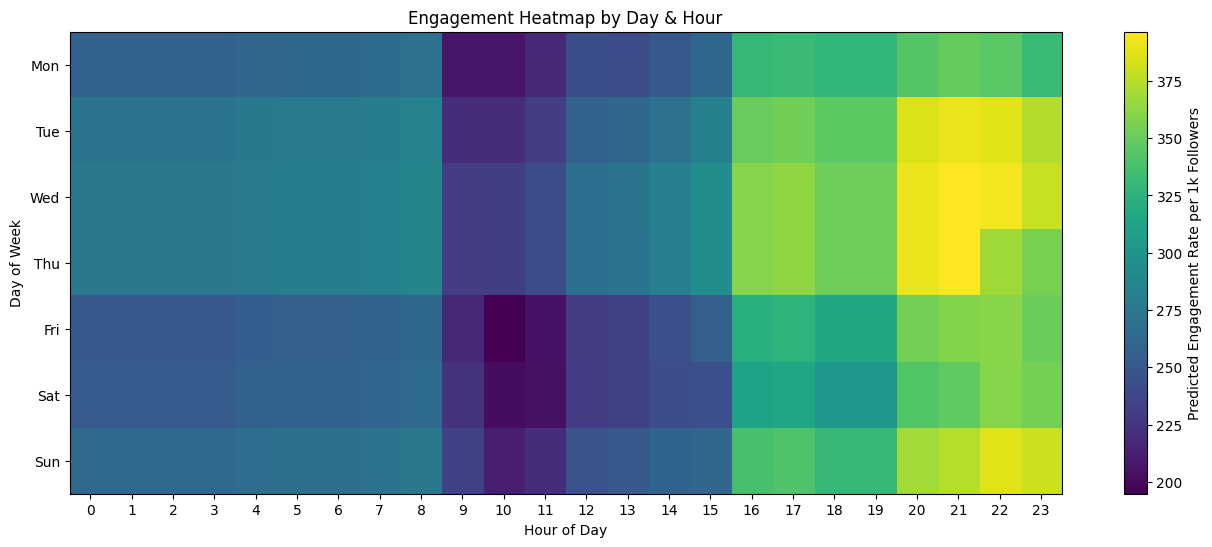

day_of_week                      2
hour_of_day                     21
predicted_engagement    396.498699
Name: 69, dtype: object


In [46]:
heatmap, df_pred = get_day_hour_heatmap( platform="Instagram",
    followers=12000,
    account_age_days=800,
    verified=0,
    media_type="image",
    location="North America",
    caption="Excited to share my AI project today! #AI #ML",
    cross_platform_spread=1)

best_index = df_pred["predicted_engagement"].idxmax()
print(df_pred.loc[best_index][["day_of_week","hour_of_day","predicted_engagement"]])


In [47]:
best_index = df_pred["predicted_engagement"].idxmax()
print(df_pred.loc[best_index][["day_of_week","hour_of_day","predicted_engagement"]])


day_of_week                      2
hour_of_day                     21
predicted_engagement    396.498699
Name: 69, dtype: object


In [48]:
best_day, best_hour, engagement = predict_best_time(
    platform="Instagram",
    followers=12000,
    account_age_days=800,
    verified=0,
    media_type="image",
    location="North America",
    caption="Excited to share my AI project today! #AI #ML",
    cross_platform_spread=1
)

print("Best Day:", best_day)
print("Best Hour:", best_hour)
print("Expected Engagement:", engagement)


/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Best Day: 2
Best Hour: 21
Expected Engagement: 396.4986992131022
